# Download multiple meteoscreening variables

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# Info about data sources of variables

- `TA`: NABEL (2004-2018), mst (2019-2021), diive (2022-2024)
- `SW_IN`: NABEL (2004-2018), mst (2019-2021), diive (2022-2024)
- `RH`: NABEL (2004-2018), mst (2019-2021), diive (2022-2024)

- `PPFD_IN`: mst (2004-2021), diive (2022-2024)
- `LW_IN`: mst (2004-2021), diive (2022-2024)

- `PA`: NABEL (2004-2005), mst (2005-2021), diive (2022-2024)

Legend:
- NABEL ... Data from [NABEL](https://www.bafu.admin.ch/bafu/en/home/topics/air/luftbelastung/national-air-pollution-monitoring-network--nabel-.html), meteoscreening with [diive](https://github.com/holukas/diive)
- mst ... Data from ETH, meteoscreening with the now deprecated MeteoscreeningTool
- diive ... Data from ETH, meteoscreening with diive

</br>

# Settings

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE

## Imports

In [2]:
from datetime import datetime
from pathlib import Path
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
import diive as dv
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.core.io.files import save_parquet
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.corrections.offsetcorrection import remove_relativehumidity_offset, remove_radiation_zero_offset
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.87.1
dbc-influxdb version: v0.13.1
Reading configuration files was successful.
Connection to database works.


</br>

</br>

# TA, SW_IN and RH

## `NABEL` data from `diive` meteoscreening (2004-2018)

### Download

In [3]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_NABEL_T1_49_1', 'RH_NABEL_T1_49_1', 'SW_IN_NABEL_T1_49_1']
MEASUREMENTS = ['TA', 'RH', 'SW']
START = '2004-01-01 00:00:01'
STOP = '2019-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_diive'

nabel_diive_ta_rh_swin_2004_2018, _, _ = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_NABEL_T1_49_1', 'RH_NABEL_T1_49_1', 'SW_IN_NABEL_T1_49_1']
    from measurements ['TA', 'RH', 'SW']
    from data version ['meteoscreening_diive']
    between 2004-01-01 00:00:01 and 2019-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2019-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "SW") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_NABEL_T1_49_1" or r["_field"] == "RH_NABEL_T1_49_1" or r["_field"] == "SW_IN_NABEL_T1_49_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2019-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurem

In [4]:
nabel_diive_ta_rh_swin_2004_2018

,RH_NABEL_T1_49_1,SW_IN_NABEL_T1_49_1,TA_NABEL_T1_49_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2018-12-31 22:00:00,99.998000,0.0,3.193900
2018-12-31 22:30:00,99.998000,0.0,3.021733
2018-12-31 23:00:00,99.998000,0.0,2.934467


### Sanitize timestamp

In [5]:
nabel_diive_ta_rh_swin_2004_2018 = TimestampSanitizer(data=nabel_diive_ta_rh_swin_2004_2018, output_middle_timestamp=False).get()
nabel_diive_ta_rh_swin_2004_2018

,RH_NABEL_T1_49_1,SW_IN_NABEL_T1_49_1,TA_NABEL_T1_49_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2018-12-31 22:00:00,99.998000,0.0,3.193900
2018-12-31 22:30:00,99.998000,0.0,3.021733
2018-12-31 23:00:00,99.998000,0.0,2.934467


### Rename variables for merging

In [6]:
renaming_dict = {
    'RH_NABEL_T1_49_1': 'RH_T1_47_1',
    'SW_IN_NABEL_T1_49_1': 'SW_IN_T1_47_1',
    'TA_NABEL_T1_49_1': 'TA_T1_47_1'
}
nabel_diive_ta_rh_swin_2004_2018 = nabel_diive_ta_rh_swin_2004_2018.rename(columns=renaming_dict)
nabel_diive_ta_rh_swin_2004_2018

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2018-12-31 22:00:00,99.998000,0.0,3.193900
2018-12-31 22:30:00,99.998000,0.0,3.021733
2018-12-31 23:00:00,99.998000,0.0,2.934467


</br>

## Data from `mst` meteoscreening (2019-2021)

### Download

In [7]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'SW']
START = '2019-01-01 00:00:01'
STOP = '2022-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_mst'

mst_ta_rh_swin_2019_2021, _, _ = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1']
    from measurements ['TA', 'RH', 'SW']
    from data version ['meteoscreening_mst']
    between 2019-01-01 00:00:01 and 2022-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2019-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "SW") |> filter(fn: (r) => r["data_version"] == "meteoscreening_mst") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 2019-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "S

In [8]:
mst_ta_rh_swin_2019_2021

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2019-01-01 00:30:00,99.997990,-2.149965,2.666350
2019-01-01 01:00:00,99.997990,-2.722333,2.475211
2019-01-01 01:30:00,99.997990,-3.087591,2.278222
2019-01-01 02:00:00,99.997990,-2.410228,2.280883
2019-01-01 02:30:00,99.997990,-2.400173,2.138061
...,...,...,...
2021-12-31 22:00:00,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,95.821067,-9.810373,7.719400


### Sanitize timestamp

In [9]:
mst_ta_rh_swin_2019_2021 = TimestampSanitizer(data=mst_ta_rh_swin_2019_2021, output_middle_timestamp=False).get()
mst_ta_rh_swin_2019_2021

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2019-01-01 00:30:00,99.997990,-2.149965,2.666350
2019-01-01 01:00:00,99.997990,-2.722333,2.475211
2019-01-01 01:30:00,99.997990,-3.087591,2.278222
2019-01-01 02:00:00,99.997990,-2.410228,2.280883
2019-01-01 02:30:00,99.997990,-2.400173,2.138061
...,...,...,...
2021-12-31 22:00:00,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,95.821067,-9.810373,7.719400


### Rename variables for merging

In [10]:
renaming_dict = {
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1'
}
mst_ta_rh_swin_2019_2021 = mst_ta_rh_swin_2019_2021.rename(columns=renaming_dict)
mst_ta_rh_swin_2019_2021

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2019-01-01 00:30:00,99.997990,-2.149965,2.666350
2019-01-01 01:00:00,99.997990,-2.722333,2.475211
2019-01-01 01:30:00,99.997990,-3.087591,2.278222
2019-01-01 02:00:00,99.997990,-2.410228,2.280883
2019-01-01 02:30:00,99.997990,-2.400173,2.138061
...,...,...,...
2021-12-31 22:00:00,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,95.821067,-9.810373,7.719400


</br>

## Data from `diive` meteoscreening (2022-2024)

### Download

In [11]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'SW']
START = '2022-01-01 00:00:01'
STOP = '2025-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_diive'

diive_ta_rh_swin_2022_2024, _, _ = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1']
    from measurements ['TA', 'RH', 'SW']
    from data version ['meteoscreening_diive']
    between 2022-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "SW") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] =

In [13]:
diive_ta_rh_swin_2022_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2022-01-01 00:30:00,89.611768,0.0,8.437600
2022-01-01 01:00:00,89.877390,0.0,8.238294
2022-01-01 01:30:00,90.451803,0.0,8.044655
2022-01-01 02:00:00,89.879497,0.0,8.111550
2022-01-01 02:30:00,89.994291,0.0,7.972055
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


### Sanitize timestamp

In [14]:
diive_ta_rh_swin_2022_2024 = TimestampSanitizer(data=diive_ta_rh_swin_2022_2024, output_middle_timestamp=False).get()
diive_ta_rh_swin_2022_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2022-01-01 00:30:00,89.611768,0.0,8.437600
2022-01-01 01:00:00,89.877390,0.0,8.238294
2022-01-01 01:30:00,90.451803,0.0,8.044655
2022-01-01 02:00:00,89.879497,0.0,8.111550
2022-01-01 02:30:00,89.994291,0.0,7.972055
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


### Rename variables for merging

In [15]:
renaming_dict = {
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1'
}
diive_ta_rh_swin_2022_2024 = diive_ta_rh_swin_2022_2024.rename(columns=renaming_dict)
diive_ta_rh_swin_2022_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2022-01-01 00:30:00,89.611768,0.0,8.437600
2022-01-01 01:00:00,89.877390,0.0,8.238294
2022-01-01 01:30:00,90.451803,0.0,8.044655
2022-01-01 02:00:00,89.879497,0.0,8.111550
2022-01-01 02:30:00,89.994291,0.0,7.972055
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


</br>

## Merge data

In [16]:
# Merge data on index
ta_rh_swin_2004_2024 = pd.concat([nabel_diive_ta_rh_swin_2004_2018, mst_ta_rh_swin_2019_2021, diive_ta_rh_swin_2022_2024], axis=0)
ta_rh_swin_2004_2024 = ta_rh_swin_2004_2024.sort_index()
ta_rh_swin_2004_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


</br>

### Sanitize timestamp

In [17]:
ta_rh_swin_2004_2024 = TimestampSanitizer(data=ta_rh_swin_2004_2024, output_middle_timestamp=False).get()
ta_rh_swin_2004_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


</br>

### Correction: Remove zero offset < 0 from `SW_IN`

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


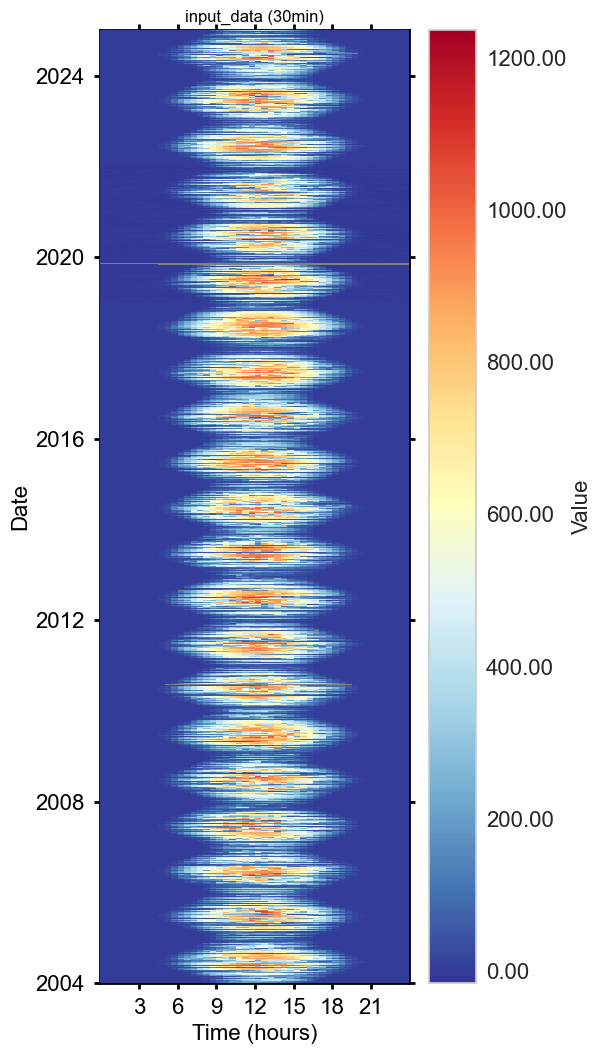

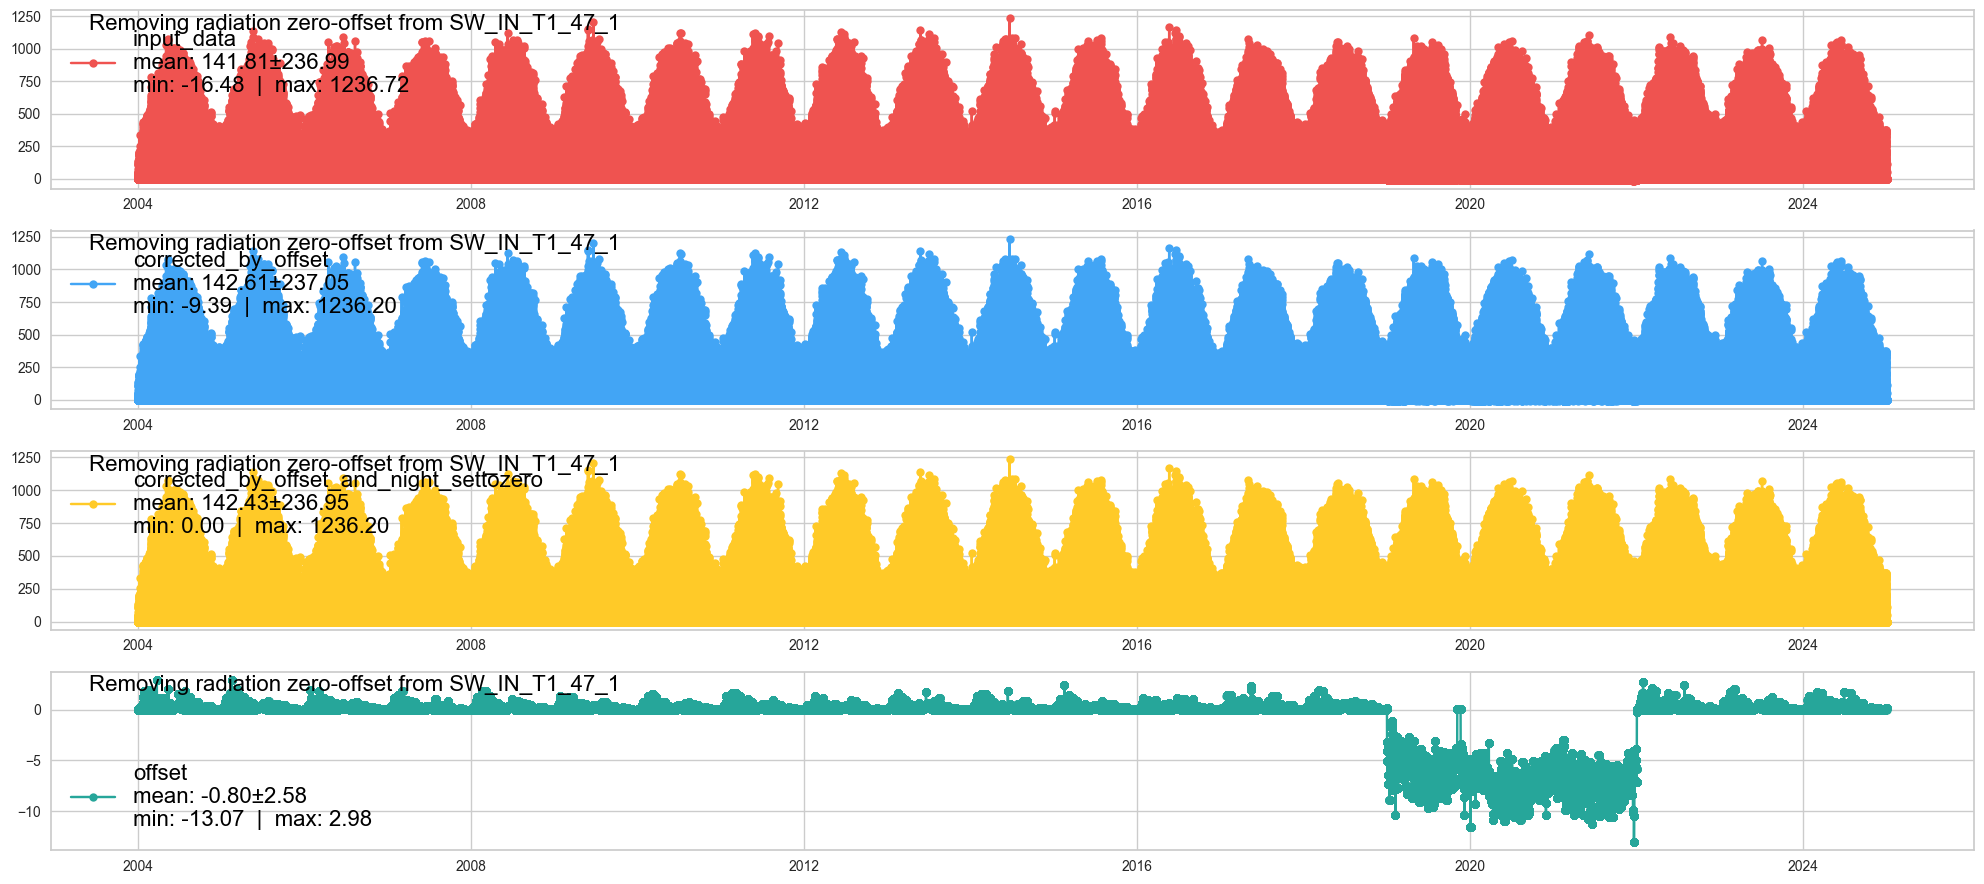

In [18]:
_swin = ta_rh_swin_2004_2024['SW_IN_T1_47_1'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
ta_rh_swin_2004_2024['SW_IN_T1_47_1'] = np.nan
ta_rh_swin_2004_2024['SW_IN_T1_47_1'] = _swin_corrected

</br>

### Correction: Remove offset >100% from `RH`

[remove_relativehumidity_offset]  running remove_relativehumidity_offset ...


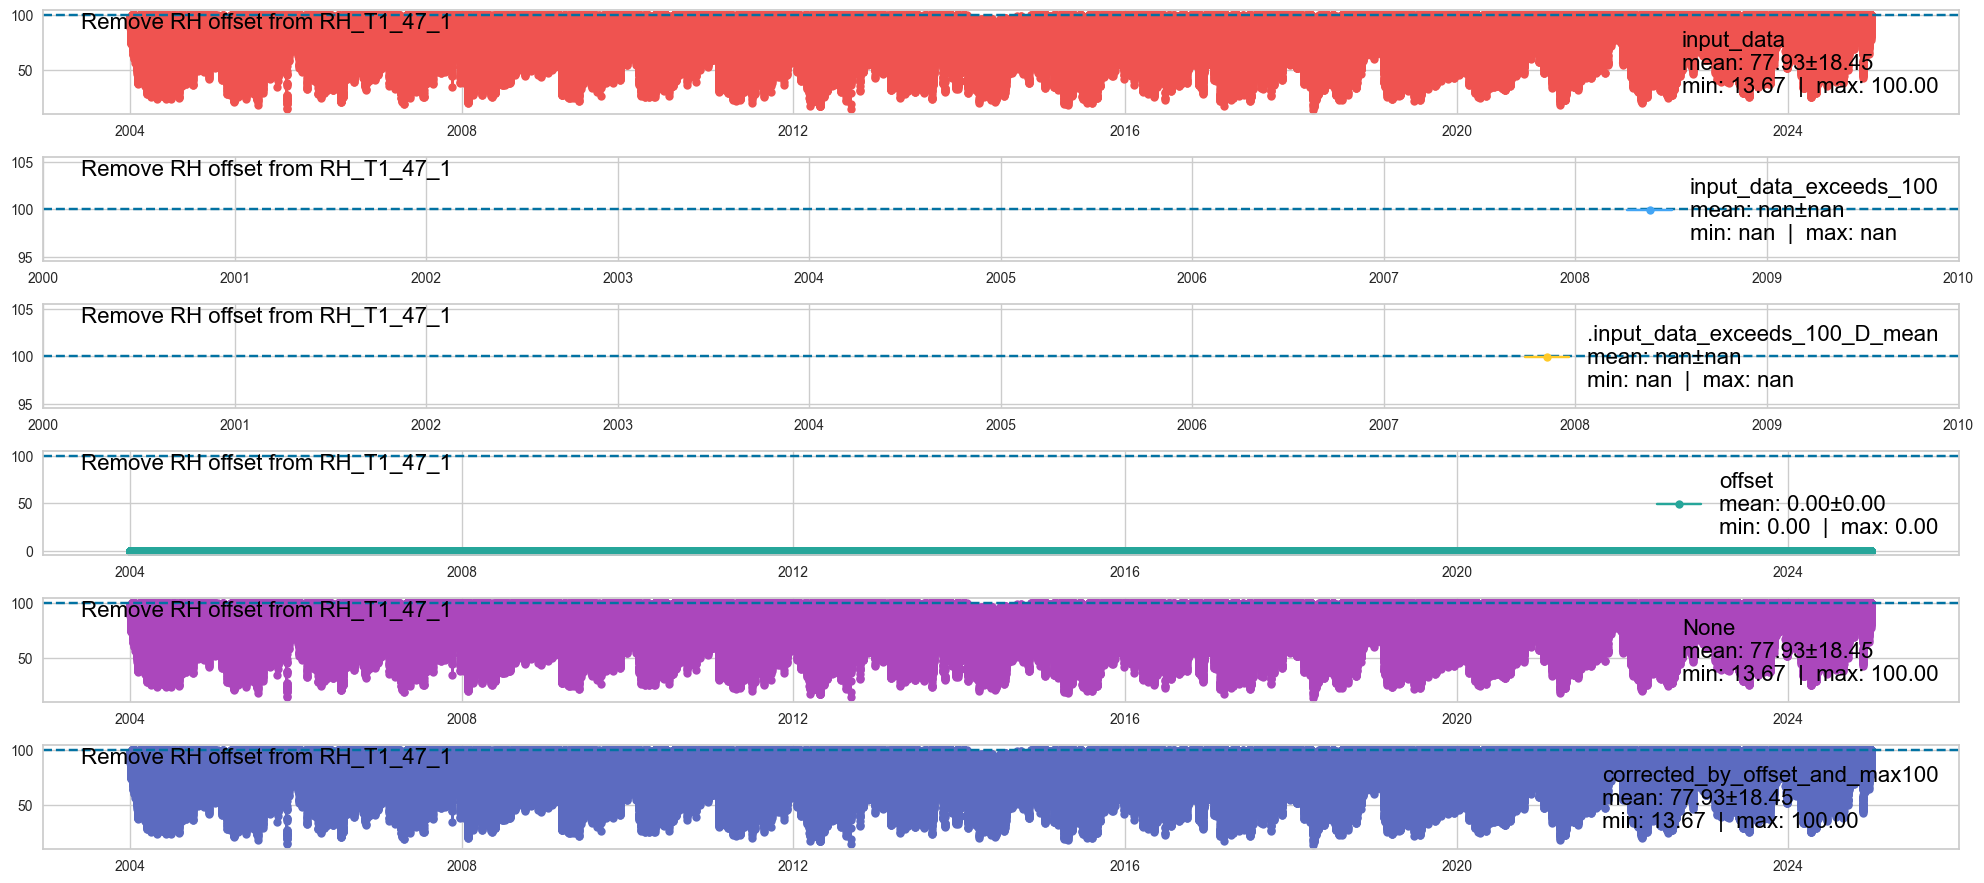

In [19]:
_rh = ta_rh_swin_2004_2024['RH_T1_47_1'].copy()
_rh_corrected = remove_relativehumidity_offset(series=_rh, showplot=True)
ta_rh_swin_2004_2024['RH_T1_47_1'] = np.nan
ta_rh_swin_2004_2024['RH_T1_47_1'] = _rh_corrected

</br>

## Dataframe

In [20]:
ta_rh_swin_2004_2024

,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,
2004-01-01 00:30:00,96.366667,0.0,-2.666667
2004-01-01 01:00:00,95.566667,0.0,-2.566667
2004-01-01 01:30:00,92.200000,0.0,-2.533333
2004-01-01 02:00:00,91.300000,0.0,-2.633333
2004-01-01 02:30:00,92.633333,0.0,-2.800000
...,...,...,...
2024-12-31 22:00:00,87.387340,0.0,-0.504794
2024-12-31 22:30:00,87.563567,0.0,-0.296828
2024-12-31 23:00:00,89.921251,0.0,-0.392922


</br>

## Plot heatmaps

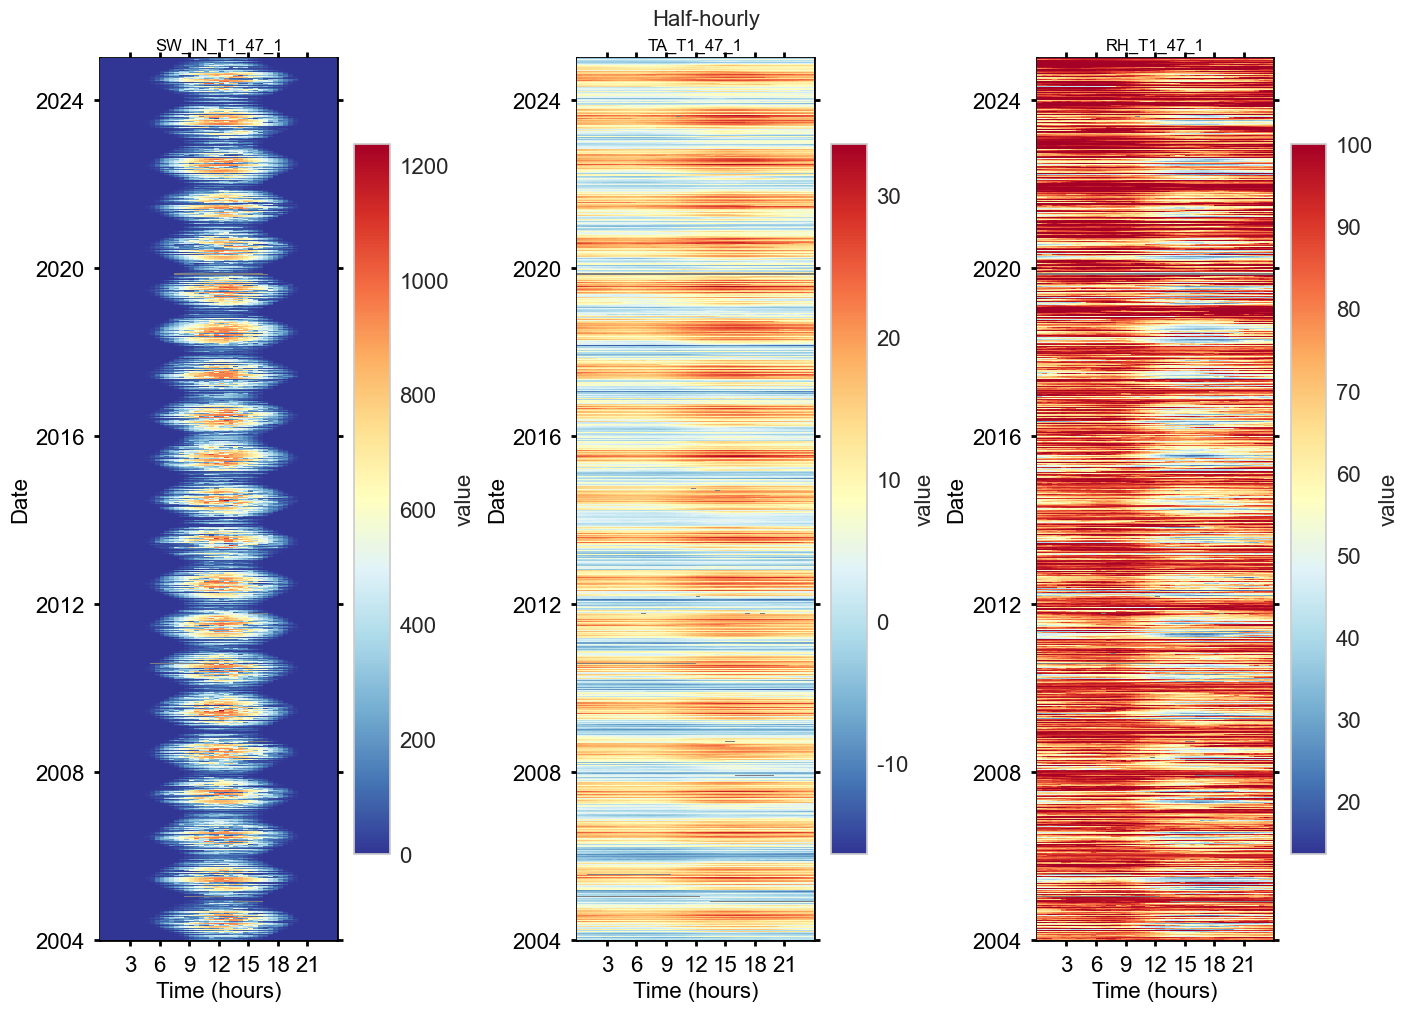

In [21]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 10), dpi=100, layout="constrained")
fig.suptitle(f'Half-hourly', fontsize=16)
dv.heatmapdatetime(series=ta_rh_swin_2004_2024['SW_IN_T1_47_1'], title="SW_IN_T1_47_1", ax=axs[0], cb_digits_after_comma=0, zlabel="value").plot()
dv.heatmapdatetime(series=ta_rh_swin_2004_2024['TA_T1_47_1'], title="TA_T1_47_1", ax=axs[1], cb_digits_after_comma=0, zlabel="value").plot()
dv.heatmapdatetime(series=ta_rh_swin_2004_2024['RH_T1_47_1'], title="RH_T1_47_1", ax=axs[2], cb_digits_after_comma=0, zlabel="value").plot()

</br>

</br>

# ---

# PPFD_IN, LW_IN

</br>

## Data from `mst` meteoscreening (2004-2021)

### Download

In [22]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['LW_IN_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['LW', 'PPFD']
START = '2004-01-01 00:00:01'
STOP = '2022-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_mst'

mst_lwin_ppfdin_2004_2021, _, _ = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['LW_IN_T1_47_1', 'PPFD_IN_T1_47_1']
    from measurements ['LW', 'PPFD']
    from data version ['meteoscreening_mst']
    between 2004-01-01 00:00:01 and 2022-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "LW" or r["_measurement"] == "PPFD") |> filter(fn: (r) => r["data_version"] == "meteoscreening_mst") |> filter(fn: (r) => r["_field"] == "LW_IN_T1_47_1" or r["_field"] == "PPFD_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "LW" or r["_measurement"] == "PPFD") |> filter(fn: (r) => r["data_version"] == "meteoscreening_mst") |> filter(fn: (r) => r["_

In [23]:
mst_lwin_ppfdin_2004_2021

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1078.000000
2004-09-20 11:30:00,NaN,889.000000
2004-09-20 12:00:00,NaN,1030.000000
2004-09-20 12:30:00,NaN,1292.000000
2004-09-20 13:00:00,NaN,750.000000
...,...,...
2021-12-31 22:00:00,280.736376,2.593284
2021-12-31 22:30:00,281.142280,2.600834
2021-12-31 23:00:00,280.816904,2.574417


### Sanitize timestamp

In [25]:
mst_lwin_ppfdin_2004_2021 = TimestampSanitizer(data=mst_lwin_ppfdin_2004_2021, output_middle_timestamp=False).get()
mst_lwin_ppfdin_2004_2021

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1078.000000
2004-09-20 11:30:00,NaN,889.000000
2004-09-20 12:00:00,NaN,1030.000000
2004-09-20 12:30:00,NaN,1292.000000
2004-09-20 13:00:00,NaN,750.000000
...,...,...
2021-12-31 22:00:00,280.736376,2.593284
2021-12-31 22:30:00,281.142280,2.600834
2021-12-31 23:00:00,280.816904,2.574417


### Correction: timestamp shift in August 2012
**Info from fieldbook entry 17 Aug 2012:**
>   adjusted the logger date and time. On Servertime (Computer System Time) 17.08.2012 12:31.42 the loggertime was 16.08.2012 08:06:00. Synchronized time at 17.08.2012 11:40:00 servertime. The logger data aquisition on the moxa embedded was restarted

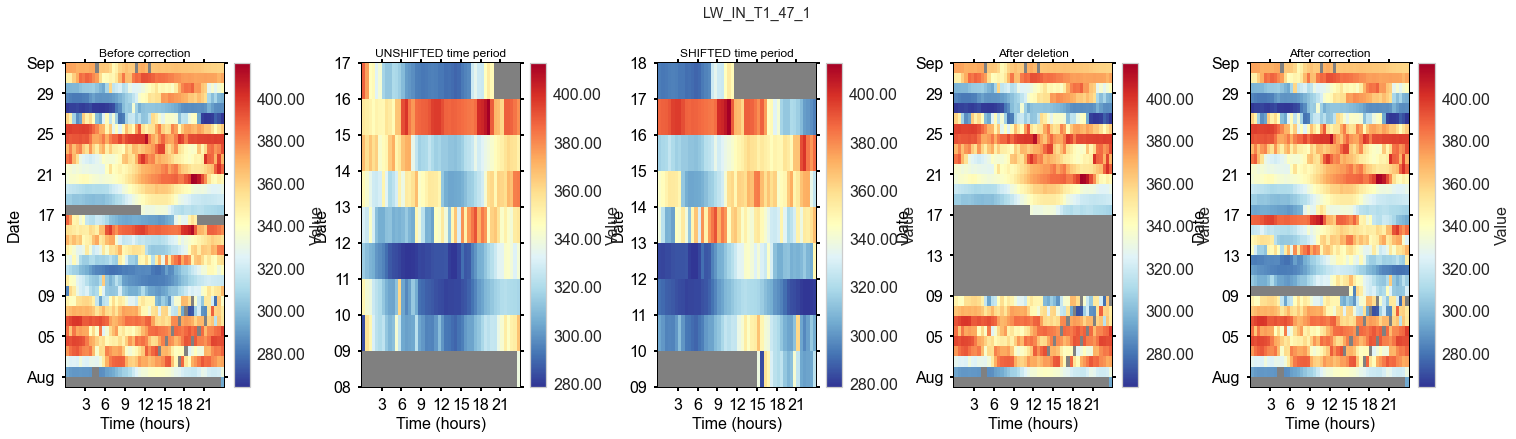

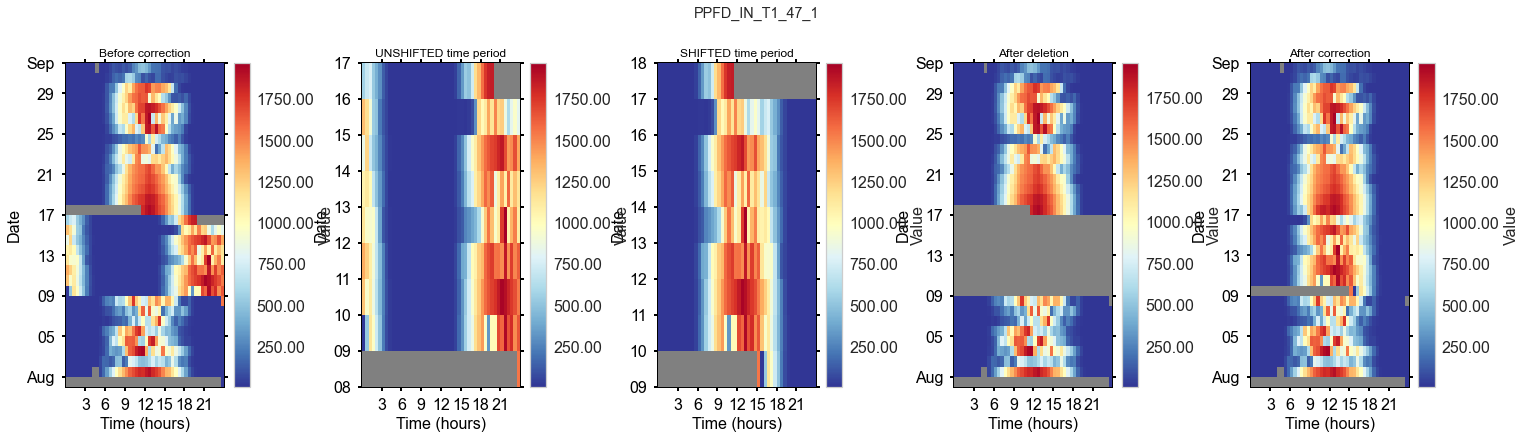

In [26]:
AFFECTED_VARS = ['LW_IN_T1_47_1', 'PPFD_IN_T1_47_1']

for av in AFFECTED_VARS:
    fig = plt.figure(figsize=(24, 6), dpi=72)
    fig.suptitle(f"{av}")
    gs = gridspec.GridSpec(1, 5)  # rows, cols
    gs.update(wspace=0.5, hspace=1, left=.1, right=.9, top=.85, bottom=.1)
    ax_before = fig.add_subplot(gs[0, 0])
    ax_unshifted = fig.add_subplot(gs[0, 1])
    ax_shifted = fig.add_subplot(gs[0, 2])
    ax_after = fig.add_subplot(gs[0, 3])
    ax_corrected = fig.add_subplot(gs[0, 4])
    
    # Show time period around issue, before correction
    # _series = mst_lwin_ppfdin_2004_2021[av].copy()
    _show_locs = (mst_lwin_ppfdin_2004_2021.index >= '2012-08-01 00:00') & (mst_lwin_ppfdin_2004_2021.index <= '2012-09-01 00:00')
    dv.heatmapdatetime(series=mst_lwin_ppfdin_2004_2021.loc[_show_locs, av], ax=ax_before, title="Before correction").plot()
    
    # Get shifted time period
    _series_corrected = mst_lwin_ppfdin_2004_2021.loc[_show_locs, av].copy()
    # Identify shifted time period
    ISSUE_START = '2012-08-09 00:00'
    ISSUE_END = '2012-08-17 00:00'
    _shifted_locs = (mst_lwin_ppfdin_2004_2021.index >= ISSUE_START) & (mst_lwin_ppfdin_2004_2021.index <= ISSUE_END)
    _series_shifted = mst_lwin_ppfdin_2004_2021.loc[_shifted_locs, av].copy()
    _series_shifted = _series_shifted.dropna()
    dv.heatmapdatetime(series=_series_shifted, ax=ax_unshifted, title="UNSHIFTED time period").plot()
    
    # Shift SW_IN by 15.5 hours during shifted time period, create corrected time series
    _series_shifted.index = _series_shifted.index + pd.Timedelta(hours=15.5)
    dv.heatmapdatetime(series=_series_shifted, ax=ax_shifted, title="SHIFTED time period").plot()
    
    # Delete data between start of issue and the last timestamp of shifted data
    _overwrite_locs = (mst_lwin_ppfdin_2004_2021.index >= ISSUE_START) & (mst_lwin_ppfdin_2004_2021.index <= _series_shifted.index[-1])
    mst_lwin_ppfdin_2004_2021.loc[_overwrite_locs, av] = np.nan
    dv.heatmapdatetime(series=mst_lwin_ppfdin_2004_2021.loc[_show_locs, av], ax=ax_after, title="After deletion").plot()
    
    # Fill in corrected values
    mst_lwin_ppfdin_2004_2021.loc[_overwrite_locs, av] = _series_shifted
    # _series_corrected = _series_corrected.combine_first(_series_shifted)
    dv.heatmapdatetime(series=mst_lwin_ppfdin_2004_2021.loc[_show_locs, av], ax=ax_corrected, title="After correction").plot()
    
    # print(_series_shifted.index[-1])
    # print(_series_shifted)
    # print(_series_corrected[_overwrite_locs])

### Rename variables for merging

In [27]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
mst_lwin_ppfdin_2004_2021 = mst_lwin_ppfdin_2004_2021.rename(columns=renaming_dict)
mst_lwin_ppfdin_2004_2021

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1078.000000
2004-09-20 11:30:00,NaN,889.000000
2004-09-20 12:00:00,NaN,1030.000000
2004-09-20 12:30:00,NaN,1292.000000
2004-09-20 13:00:00,NaN,750.000000
...,...,...
2021-12-31 22:00:00,280.736376,2.593284
2021-12-31 22:30:00,281.142280,2.600834
2021-12-31 23:00:00,280.816904,2.574417


</br>

## Data from `diive` meteoscreening (2022-2024)

### Download

In [28]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['LW_IN_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['LW', 'PPFD']
START = '2022-01-01 00:00:01'
STOP = '2025-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_diive'

diive_lwin_ppfdin_2022_2024, _, _ = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['LW_IN_T1_47_1', 'PPFD_IN_T1_47_1']
    from measurements ['LW', 'PPFD']
    from data version ['meteoscreening_diive']
    between 2022-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "LW" or r["_measurement"] == "PPFD") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "LW_IN_T1_47_1" or r["_field"] == "PPFD_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "LW" or r["_measurement"] == "PPFD") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) =

In [29]:
diive_lwin_ppfdin_2022_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2022-01-01 00:30:00,281.339657,0.0
2022-01-01 01:00:00,280.357413,0.0
2022-01-01 01:30:00,279.863157,0.0
2022-01-01 02:00:00,280.836867,0.0
2022-01-01 02:30:00,280.860203,0.0
...,...,...
2024-12-31 22:00:00,232.595527,0.0
2024-12-31 22:30:00,232.609777,0.0
2024-12-31 23:00:00,232.345020,0.0


### Sanitize timestamp

In [30]:
diive_lwin_ppfdin_2022_2024 = TimestampSanitizer(data=diive_lwin_ppfdin_2022_2024, output_middle_timestamp=False).get()
diive_lwin_ppfdin_2022_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2022-01-01 00:30:00,281.339657,0.0
2022-01-01 01:00:00,280.357413,0.0
2022-01-01 01:30:00,279.863157,0.0
2022-01-01 02:00:00,280.836867,0.0
2022-01-01 02:30:00,280.860203,0.0
...,...,...
2024-12-31 22:00:00,232.595527,0.0
2024-12-31 22:30:00,232.609777,0.0
2024-12-31 23:00:00,232.345020,0.0


### Rename variables for merging

In [31]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
diive_lwin_ppfdin_2022_2024 = diive_lwin_ppfdin_2022_2024.rename(columns=renaming_dict)
diive_lwin_ppfdin_2022_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2022-01-01 00:30:00,281.339657,0.0
2022-01-01 01:00:00,280.357413,0.0
2022-01-01 01:30:00,279.863157,0.0
2022-01-01 02:00:00,280.836867,0.0
2022-01-01 02:30:00,280.860203,0.0
...,...,...
2024-12-31 22:00:00,232.595527,0.0
2024-12-31 22:30:00,232.609777,0.0
2024-12-31 23:00:00,232.345020,0.0


</br>

## Merge data

In [35]:
# Merge data on index
lwin_ppfdin_2004_2024 = pd.concat([mst_lwin_ppfdin_2004_2021, diive_lwin_ppfdin_2022_2024], axis=0)
lwin_ppfdin_2004_2024 = lwin_ppfdin_2004_2024.sort_index()
lwin_ppfdin_2004_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1078.0
2004-09-20 11:30:00,NaN,889.0
2004-09-20 12:00:00,NaN,1030.0
2004-09-20 12:30:00,NaN,1292.0
2004-09-20 13:00:00,NaN,750.0
...,...,...
2024-12-31 22:00:00,232.595527,0.0
2024-12-31 22:30:00,232.609777,0.0
2024-12-31 23:00:00,232.345020,0.0


</br>

### Sanitize timestamp

In [36]:
lwin_ppfdin_2004_2024 = TimestampSanitizer(data=lwin_ppfdin_2004_2024, output_middle_timestamp=False).get()
lwin_ppfdin_2004_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1078.0
2004-09-20 11:30:00,NaN,889.0
2004-09-20 12:00:00,NaN,1030.0
2004-09-20 12:30:00,NaN,1292.0
2004-09-20 13:00:00,NaN,750.0
...,...,...
2024-12-31 22:00:00,232.595527,0.0
2024-12-31 22:30:00,232.609777,0.0
2024-12-31 23:00:00,232.345020,0.0


</br>

### Correction: Remove zero offset < 0 from `PPFD_IN`

[remove_radiation_zero_offset]  running remove_radiation_zero_offset ...


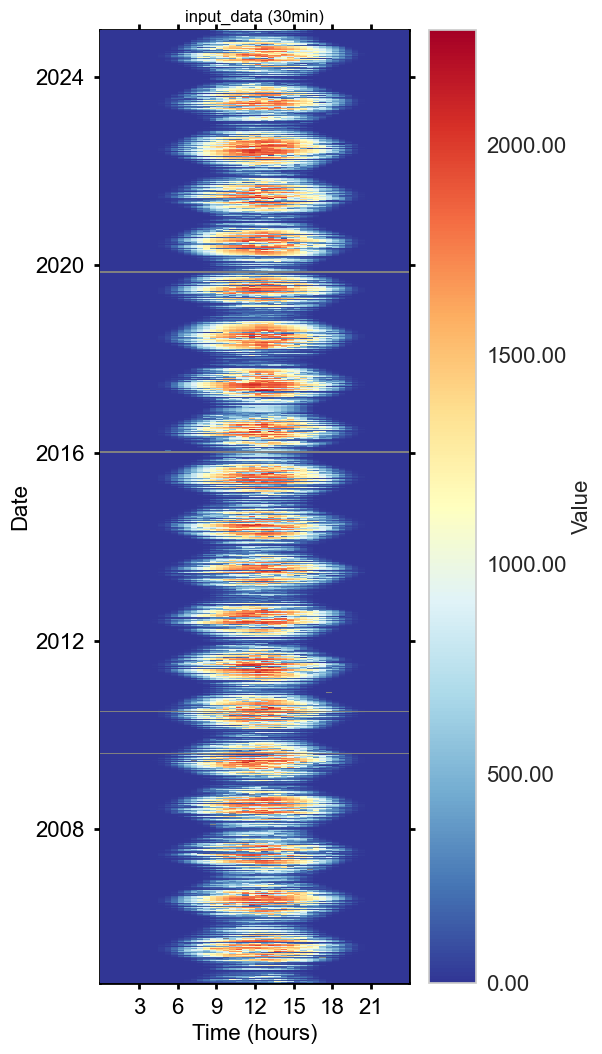

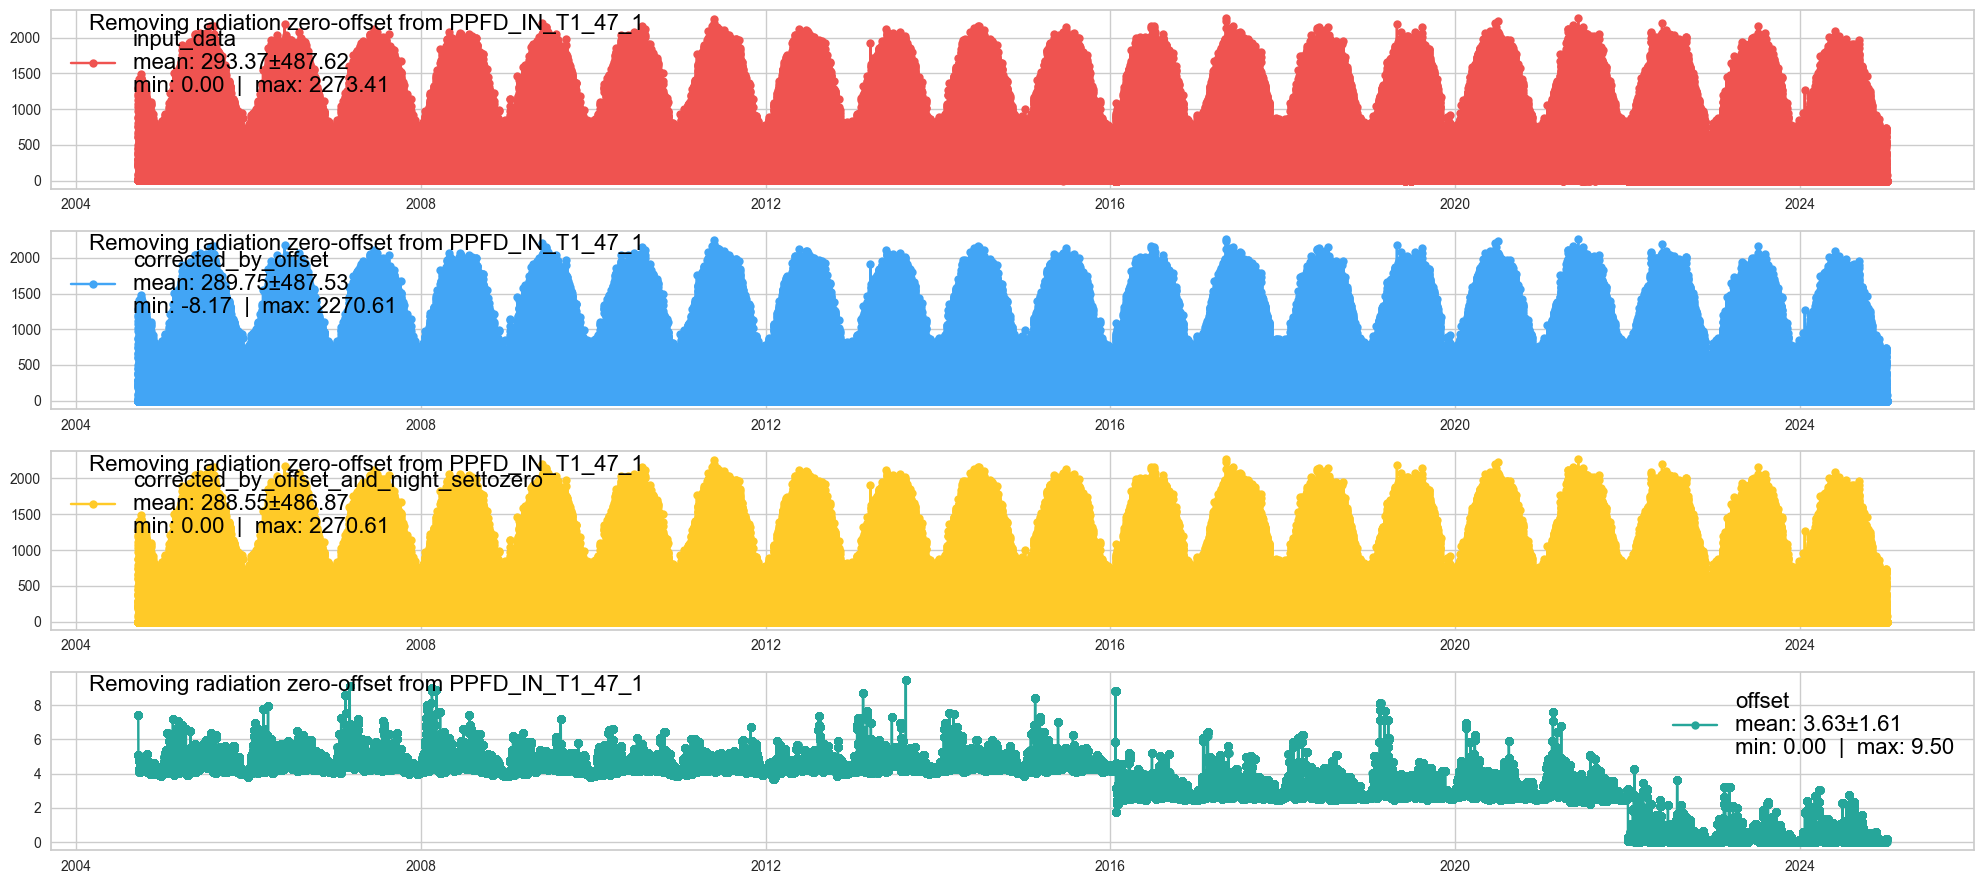

In [37]:
_ppfdin = lwin_ppfdin_2004_2024['PPFD_IN_T1_47_1'].copy()
_ppfdin_corrected = remove_radiation_zero_offset(series=_ppfdin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
lwin_ppfdin_2004_2024['PPFD_IN_T1_47_1'] = np.nan
lwin_ppfdin_2004_2024['PPFD_IN_T1_47_1'] = _ppfdin_corrected

</br>

## Dataframe

In [38]:
lwin_ppfdin_2004_2024

,LW_IN_T1_47_1,PPFD_IN_T1_47_1
TIMESTAMP_END,,
2004-09-20 11:00:00,NaN,1070.543364
2004-09-20 11:30:00,NaN,881.543364
2004-09-20 12:00:00,NaN,1022.543364
2004-09-20 12:30:00,NaN,1284.543364
2004-09-20 13:00:00,NaN,742.543364
...,...,...
2024-12-31 22:00:00,232.595527,0.000000
2024-12-31 22:30:00,232.609777,0.000000
2024-12-31 23:00:00,232.345020,0.000000


</br>

## Plot heatmaps

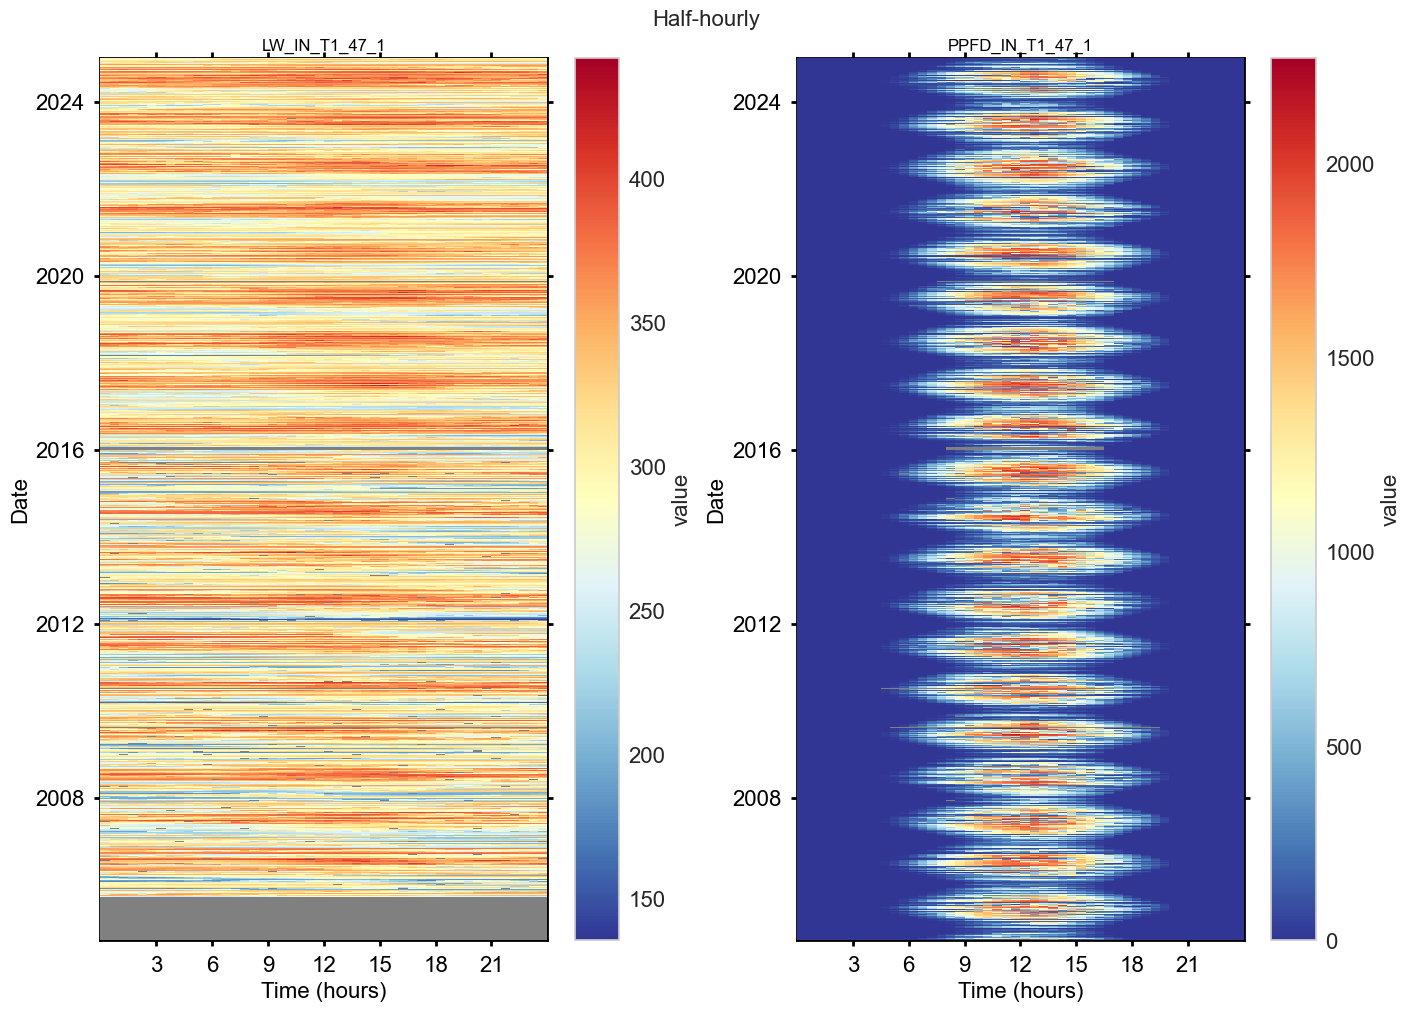

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 10), dpi=100, layout="constrained")
fig.suptitle(f'Half-hourly', fontsize=16)
dv.heatmapdatetime(series=lwin_ppfdin_2004_2024['LW_IN_T1_47_1'], title="LW_IN_T1_47_1", ax=axs[0], cb_digits_after_comma=0, zlabel="value").plot()
dv.heatmapdatetime(series=lwin_ppfdin_2004_2024['PPFD_IN_T1_47_1'], title="PPFD_IN_T1_47_1", ax=axs[1], cb_digits_after_comma=0, zlabel="value").plot()

</br>

</br>

</br>

</br>

</br>

# ---

# Data from `diive` meteoscreening (2022-2024)

## Download

In [ ]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
START = '2022-01-01 00:00:01'
STOP = '2025-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_diive'

data_simple_diive, data_detailed_diive, assigned_measurements_diive = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)

In [ ]:
data_simple_diive

## Sanitize timestamp

In [ ]:
data_simple_diive = TimestampSanitizer(data=data_simple_diive, output_middle_timestamp=False).get()
data_simple_diive

## Correction: adjust units `PA`

In [ ]:
# Convert units from Pa to kPa
data_simple_diive['PA_T1_47_1'] = data_simple_diive['PA_T1_47_1'].divide(1000)
data_simple_diive

## Rename variables for merging

In [ ]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
data_simple_diive = data_simple_diive.rename(columns=renaming_dict)
data_simple_diive

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

# Data from `mst` meteoscreening (2004-2021)

## Download

In [ ]:
%%time

BUCKET = f'ch-lae_processed'
FIELDS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']
MEASUREMENTS = ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
START = '2004-01-01 00:00:01'
STOP = '2022-01-01 00:00:01'
DATA_VERSION = 'meteoscreening_mst'

data_simple_mst, data_detailed_mst, assigned_measurements_mst = dbc.download(
    bucket=BUCKET,
    measurements=MEASUREMENTS,
    fields=FIELDS,
    start=START,  # Download data starting with this date (the start date itself IS included),
    stop=STOP,  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)

In [ ]:
data_simple_mst

## Sanitize timestamp

In [ ]:
data_simple_mst = TimestampSanitizer(data=data_simple_mst, output_middle_timestamp=False).get()
data_simple_mst

## Correction: timestamp shift in August 2012
**Info from fieldbook entry 17 Aug 2012:**
>   adjusted the logger date and time. On Servertime (Computer System Time) 17.08.2012 12:31.42 the loggertime was 16.08.2012 08:06:00. Synchronized time at 17.08.2012 11:40:00 servertime. The logger data aquisition on the moxa embedded was restarted

In [ ]:
AFFECTED_VARS = ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1', 'PA_T1_47_1', 'PPFD_IN_T1_47_1']

for av in AFFECTED_VARS:
    fig = plt.figure(figsize=(24, 6), dpi=72)
    fig.suptitle(f"{av}")
    gs = gridspec.GridSpec(1, 5)  # rows, cols
    gs.update(wspace=0.5, hspace=1, left=.1, right=.9, top=.85, bottom=.1)
    ax_before = fig.add_subplot(gs[0, 0])
    ax_unshifted = fig.add_subplot(gs[0, 1])
    ax_shifted = fig.add_subplot(gs[0, 2])
    ax_after = fig.add_subplot(gs[0, 3])
    ax_corrected = fig.add_subplot(gs[0, 4])
    
    # Show time period around issue, before correction
    # _series = data_simple_mst[av].copy()
    _show_locs = (data_simple_mst.index >= '2012-08-01 00:00') & (data_simple_mst.index <= '2012-09-01 00:00')
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_before, title="Before correction").plot()
    
    # Get shifted time period
    _series_corrected = data_simple_mst.loc[_show_locs, av].copy()
    # Identify shifted time period
    ISSUE_START = '2012-08-09 00:00'
    ISSUE_END = '2012-08-17 00:00'
    _shifted_locs = (data_simple_mst.index >= ISSUE_START) & (data_simple_mst.index <= ISSUE_END)
    _series_shifted = data_simple_mst.loc[_shifted_locs, av].copy()
    _series_shifted = _series_shifted.dropna()
    dv.heatmapdatetime(series=_series_shifted, ax=ax_unshifted, title="UNSHIFTED time period").plot()
    
    # Shift SW_IN by 15.5 hours during shifted time period, create corrected time series
    _series_shifted.index = _series_shifted.index + pd.Timedelta(hours=15.5)
    dv.heatmapdatetime(series=_series_shifted, ax=ax_shifted, title="SHIFTED time period").plot()
    
    # Delete data between start of issue and the last timestamp of shifted data
    _overwrite_locs = (data_simple_mst.index >= ISSUE_START) & (data_simple_mst.index <= _series_shifted.index[-1])
    data_simple_mst.loc[_overwrite_locs, av] = np.nan
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_after, title="After deletion").plot()
    
    # Fill in corrected values
    data_simple_mst.loc[_overwrite_locs, av] = _series_shifted
    # _series_corrected = _series_corrected.combine_first(_series_shifted)
    dv.heatmapdatetime(series=data_simple_mst.loc[_show_locs, av], ax=ax_corrected, title="After correction").plot()
    
    # print(_series_shifted.index[-1])
    # print(_series_shifted)
    # print(_series_corrected[_overwrite_locs])

## Rename variables for merging

In [ ]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_47_1': 'PPFD_IN_T1_47_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_T1_47_1': 'PA_T1_47_1'
}
data_simple_mst = data_simple_mst.rename(columns=renaming_dict)
data_simple_mst

</br>

# Merge data

In [ ]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_diive, data_simple_mst], axis=0)
data_simple_merged = data_simple_merged.sort_index()
data_simple_merged

</br>

## Set start date to 1 Jan 2004

In [ ]:
# # Define the date for the new row
# start_date = pd.to_datetime('2004-01-01 00:30:00')

# # Create a new DataFrame for this single row
# # Initialize with NaN values for all columns that exist in the original DataFrame
# new_row_data = {col: [np.nan] for col in data_simple_merged.columns}
# new_row_df = pd.DataFrame(new_row_data, index=[start_date])

# # Concatenate the new row DataFrame with the original DataFrame
# # Use sort_index() to ensure the combined DataFrame is in chronological order
# data_simple_merged = pd.concat([new_row_df, data_simple_merged]).sort_index()
# data_simple_merged.index.name = "TIMESTAMP_END"
# data_simple_merged

</br>

## Sanitize timestamp

In [ ]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

</br>

## Correction: Remove zero offset < 0 from `SW_IN`

In [ ]:
_swin = data_simple_merged['SW_IN_T1_47_1'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_merged['SW_IN_T1_47_1'] = np.nan
data_simple_merged['SW_IN_T1_47_1'] = _swin_corrected

</br>

## Correction: Remove zero offset < 0 from `PPFD_IN`

In [ ]:
_ppfdin = data_simple_merged['PPFD_IN_T1_47_1'].copy()
_ppfdin_corrected = remove_radiation_zero_offset(series=_ppfdin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_merged['PPFD_IN_T1_47_1'] = np.nan
data_simple_merged['PPFD_IN_T1_47_1'] = _ppfdin_corrected

</br>

## Correction: Remove offset >100% from `RH`

In [ ]:
_rh = data_simple_merged['RH_T1_47_1'].copy()
_rh_corrected = remove_relativehumidity_offset(series=_rh, showplot=True)
data_simple_merged['RH_T1_47_1'] = np.nan
data_simple_merged['RH_T1_47_1'] = _rh_corrected

</br>

# Plot

In [ ]:
_plot_df = data_simple_merged[FIELDS].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

In [ ]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Meteo data", alpha=.9, x_compat=True);

## Heatmaps

In [ ]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# Save to file

In [ ]:
OUTNAME = "12.1_METEO6_NOT-GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=data_simple_merged, outpath=OUTPATH)
data_simple_merged.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

</br>

# End of notebook.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

</br>